In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Installing all the dependencies of spark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=06132cf1db897e44be9ee562a3910c06c288056e8b08c9de263c4360c66bcfc2
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
# import pyspark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, date_trunc, desc, asc, to_date
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import Window

from pyspark.ml.feature import OneHotEncoder, IndexToString, StringIndexer, Normalizer, StandardScaler, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import python libraries
import datetime as dt
import numpy as np
import pandas as pd

In [ ]:
# Importing and configuration of Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()

In [ ]:
# As we have already learnt about reading a Dataframe in our previous notebooks so we would directly read our notebook now
data=spark.read.csv('/content/drive/MyDrive/code_files/Sri/Pyspark/Bank Churn Prediction/churn.csv',inferSchema=True,header=True)
# By default the show function will give us  20 rows but if need fewer rows then we can mention as a parameter inside the function.
data.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [ ]:
data.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [ ]:
# inorder to get the functionality of data.shape as we used in pandas we can do in this way over here
print('Without any conversion: ',(data.count(), len(data.columns)))
# or if the dataset is small we can convert this into pandas dataframe and then use the functionallity of pandas
# we can observe that both of them will return same value
import pandas as pd    
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
pandasDF=data.toPandas()
print('By converting from spark to Pandas: ',pandasDF.shape)

Without any conversion:  (10000, 14)
By converting from spark to Pandas:  (10000, 14)


In [ ]:
data.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [ ]:
pandasDF.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
for i in data.columns:
  print("missing in",i,data.filter(data[i].isNull()).count())

missing in RowNumber 0
missing in CustomerId 0
missing in Surname 0
missing in CreditScore 0
missing in Geography 0
missing in Gender 0
missing in Age 0
missing in Tenure 0
missing in Balance 0
missing in NumOfProducts 0
missing in HasCrCard 0
missing in IsActiveMember 0
missing in EstimatedSalary 0
missing in Exited 0


In [ ]:
# Here we will be checking the null values present in each column
for i in data.columns:
  print("missing in",i,data.filter(data[i].isNull()).show())

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+

missing in RowNumber None
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+----------

In [ ]:
data.describe().show()

+-------+-----------------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+
|summary|       CustomerId|         CredRate|Geography|Gender|               Age|            Tenure|          Balance|       Prod Number|          HasCrCard|             ActMem|   EstimatedSalary|             Exited|
+-------+-----------------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+
|  count|            10000|            10000|    10000|  9996|              9994|             10000|            10000|             10000|              10000|              10000|              9996|              10000|
|   mean|  1.56909405694E7|         650.5288|     null|  null|38.925255153091854|            5.0128|76485.88928799961|            1.

In [ ]:
data.groupBy('HasCrCard').count().show()

+---------+-----+
|HasCrCard|count|
+---------+-----+
|        1| 7055|
|        0| 2945|
+---------+-----+



We have got an  output that shows the number of 1s as 7055 and the number of 0s as 2945. This shows that approximately 70% of the customers have
a credit card and 29% of them do not have a credit card.

In [ ]:
data=data.withColumnRenamed("CredRate","CreditScore")
data=data.withColumnRenamed("ActMem","IsActiveMember")
data=data.withColumnRenamed("Prod Number","NumOfProducts")
data=data.withColumnRenamed("Exited","Churned")
data.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Churned']

In [ ]:
#Move the churn column to the right and drop the CustomerId column using the following code
data=data.withColumn('churn',data['Churned'])
data=data.drop('CustomerId')
data=data.drop('Churned')

In [ ]:
data.show()

+---------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+-----+
|RowNumber|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|churn|
+---------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+-----+
|        1| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|    1|
|        2|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|    0|
|        3|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|    1|
|        4|     Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|    0|
|        5| Mitchell|        850|    Spain|Female| 43|     2|125510.8

In [ ]:
data.dtypes

[('RowNumber', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('churn', 'int')]

Converting the columns with categorical values into string types so that we can embed them using stringindexer or OneHotEncoding.

In [ ]:
from pyspark.sql.types import StringType
data = data.withColumn("HasCrCard",data["HasCrCard"].cast(StringType()))
data = data.withColumn("churn",data["churn"].cast(StringType()))
data = data.withColumn("IsActiveMember",data["IsActiveMember"].cast(StringType()))

checking whether the datatypes have been converted

In [ ]:
data.dtypes

[('RowNumber', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'string'),
 ('IsActiveMember', 'string'),
 ('EstimatedSalary', 'double'),
 ('churn', 'string')]

###<u> Exploring the Data</u>


#### Obtaining the Statistical Overview and correlation plot<br></u>
Here we will find out the number of customers that churned using basic exploration techniques. The churn column has two attributes: 0 means
that the customer did not churn and 1 implies that the customer churned.

Inspecting the target variable to see how many of the customers have churned

In [ ]:
#Inspect the target variable to see how many of the customers have churned.
data.groupBy('churn').count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    0| 7963|
|    1| 2037|
+-----+-----+



The output shows us that 7963 customers did not churn, whereas 2037 customers churned.

Inspect the number of active members in the bank

In [ ]:
data.groupBy('IsActiveMember').count().show()

+--------------+-----+
|IsActiveMember|count|
+--------------+-----+
|             0| 4849|
|             1| 5151|
+--------------+-----+



The output shows us that 5151 customers are active, whereas 4849 customers are not active

#####Getting statistical overview<br></u>
Inspect some of the statistics, such as mean and max in the above figure. These statistics help us answer questions such as the average age, salary, and
number of products held by our customers, or the maximum and minimum number of products held by our customer base. These statistics would be
useful for the marketing team and senior management

In [ ]:
data.describe().show()

+-------+------------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|              churn|
+-------+------------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|   null|         650.5288|     null|  null|           38.9218|          

#####Inspect the mean attributes of customers who churned compared to those who did not churn

In [ ]:
summary_churn = data.groupby('churn')
summary_churn.mean().show()

+-----+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+--------------------+
|churn|   avg(RowNumber)| avg(CreditScore)|         avg(Age)|      avg(Tenure)|     avg(Balance)|avg(NumOfProducts)|avg(EstimatedSalary)|
+-----+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+--------------------+
|    0|5024.694964209469|651.8531960316463|37.40838879819164|5.033278914981791|72745.29677885193|1.5442672359663443|   99738.39177194514|
|    1|4905.917525773196|645.3514972999509| 44.8379970544919|4.932744231713304|91108.53933726063|1.4752086401570939|   101465.6775306824|
+-----+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+--------------------+



From this you can infer that the average credit score of customers that churned is 645.35, and the average age of the customers that
churned is 44.83 years. The average balance and the estimated salary of the customers that churned are 911,108.53 USD and 101,465.67 USD,
respectively, which is greater than the values for customers that didn't churn.

#### checking for correlation in our data </u>
Here we will convert the spark dataframe to pandas dataframe to use the functionality of pandas

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
RowNumber,1.000000,0.005840,0.000783,-0.006495,-0.009067,0.007246,-0.005988
CreditScore,0.005840,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.001384
Age,0.000783,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.007201
Tenure,-0.006495,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.007784
Balance,-0.009067,0.006268,0.028308,-0.012254,1.000000,-0.304180,0.012797
NumOfProducts,0.007246,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.014204
EstimatedSalary,-0.005988,-0.001384,-0.007201,0.007784,0.012797,0.014204,1.000000


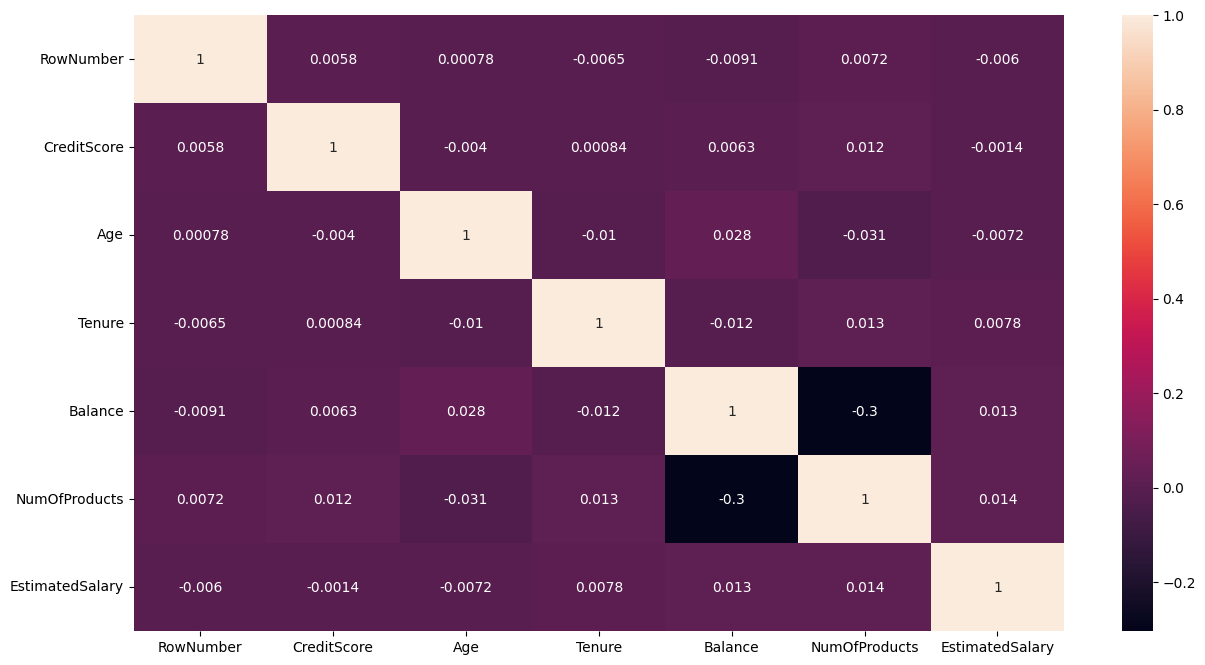

In [ ]:
# we will get it into pandas dataframe and perform the correlation analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pdf = data.toPandas()
corr = pdf.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)
corr

From the correlation plot, it appears that there is a negative (-0.3%) relationship between the number of products purchased and the balance.

####Visualizing the Data<br></u>
The best way to perform data exploration is to visualize the data to find out how each of the variables are interacting with each other.

In [ ]:
# code to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#####univariate analysis </u>
Plot the distribution graph of the customers for the EstimatedSalary , Age , and Balance columns.

Text(0, 0.5, 'No of Customers')

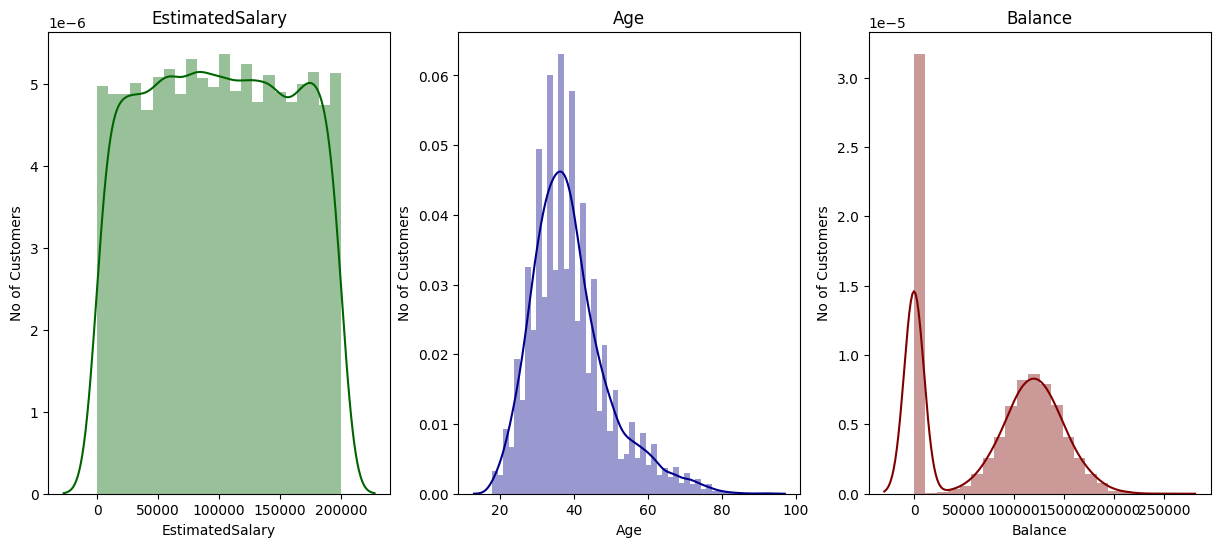

In [ ]:
# point to be noted : Here we are using the pandas dataframe that we created from our data by converting the spark dataframe to pandas dataframe
f, axes = plt.subplots(ncols=3, figsize=(15, 6))
sns.distplot(pdf.EstimatedSalary, kde=True, color="darkgreen", ax=axes[0]).set_title('EstimatedSalary')
axes[0].set_ylabel('No of Customers')
sns.distplot(pdf.Age, kde=True, color="darkblue", ax=axes[1]).set_title('Age')
axes[1].set_ylabel('No of Customers')
sns.distplot(pdf.Balance, kde=True, color="maroon", ax=axes[2]).set_title('Balance')
axes[2].set_ylabel('No of Customers')

The following are the observations from the univariate analysis:<br>
1. EstimatedSalary: The distribution of the estimated salary seems to be a plateau distribution.
2. Age: This has a normal distribution that is right skewed. Most customers lie in the range of 30-45 years of age.
3. Balance: This has a bimodal distribution. A considerable number of customers with a low balance are there, which seems to be an outlier.

##### Bivariate analysis</u>
Inspect whether there is a difference in churn for gender using bivariate analysis. Use the following code:

Text(0.5, 1.0, 'Customer Churn Distribution by Gender')

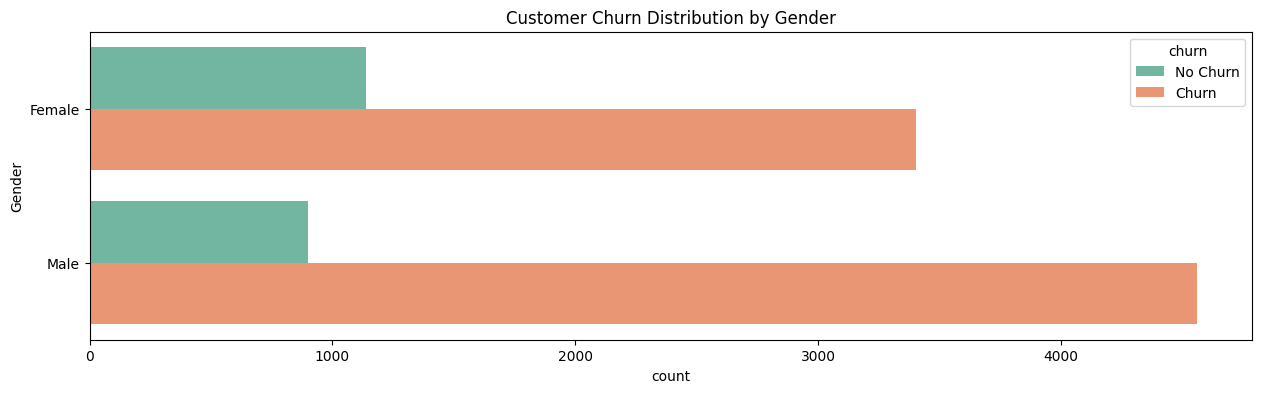

In [ ]:
plt.figure(figsize=(15,4))
p=sns.countplot(y="Gender", hue='churn', data=pdf,palette="Set2")
legend = p.get_legend()
legend_txt = legend.texts
legend_txt[0].set_text("No Churn")
legend_txt[1].set_text("Churn")
p.set_title('Customer Churn Distribution by Gender')

You will observe that comparatively, more female customers have churned. Also, the amount of churn for customers with 3-4 products is higher.

##### plotting geography vs churn

Text(0.5, 1.0, 'Customer Geography Distribution')

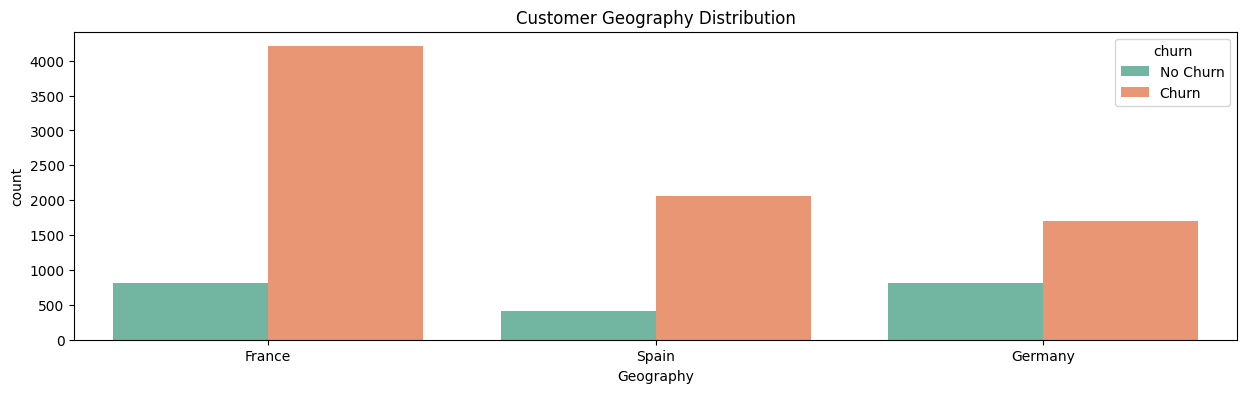

In [ ]:
plt.figure(figsize=(15,4))
p=sns.countplot(x='Geography', hue='churn',data=pdf, palette="Set2")
legend = p.get_legend()
legend_txt = legend.texts
legend_txt[0].set_text("No Churn")
legend_txt[1].set_text("Churn")
p.set_title('Customer Geography Distribution')

We can observe that the difference between number of customers that churned and those that did not churn is lesser for Germany and Spain is comparison with
France. Germany has the highest number of customers compared to other countries.

##### Plotting NumOfProducts versus Churn :

Text(0.5, 1.0, 'Customer Distribution by Product')

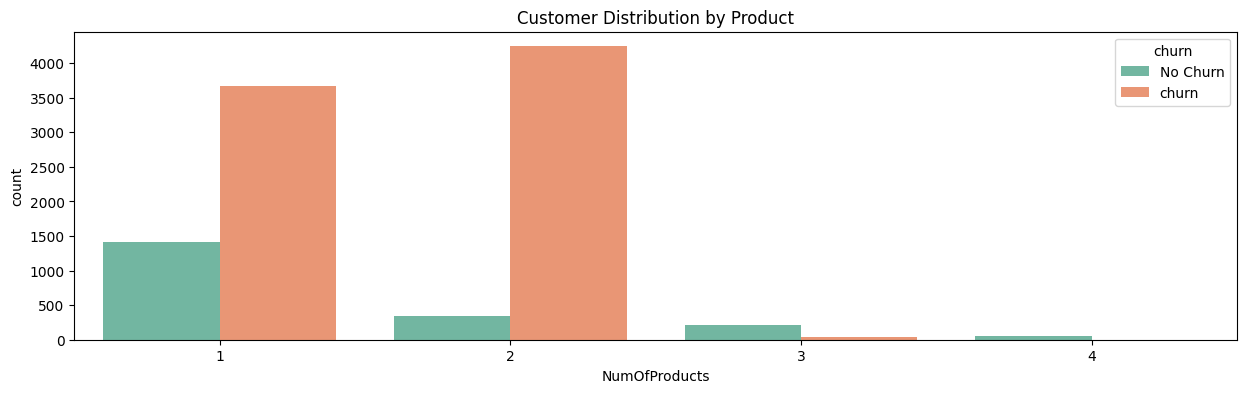

In [ ]:
plt.figure(figsize=(15,4))
p=sns.countplot(x='NumOfProducts', hue='churn',data=pdf, palette="Set2")
legend = p.get_legend()
legend_txt = legend.texts
legend_txt[0].set_text("No Churn")
legend_txt[1].set_text("churn")
p.set_title('Customer Distribution by Product')

##### Plot Balance versus NumOfProducts by Churn :

Text(0.5, 1.0, 'Number of Product VS Balance')

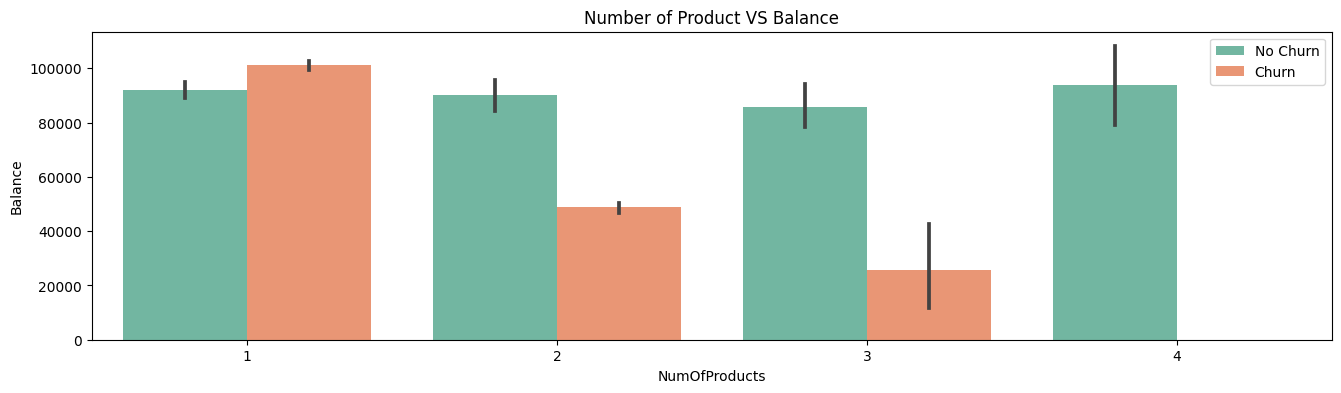

In [ ]:
plt.figure(figsize=(16,4))
p=sns.barplot(x='NumOfProducts',y='Balance',hue='churn',data=pdf, palette="Set2")
p.legend(loc='upper right')
legend = p.get_legend()
legend_txt = legend.texts
legend_txt[0].set_text("No Churn")
legend_txt[1].set_text("Churn")
p.set_title('Number of Product VS Balance')

From the above figure, it appears that as the number of products increases, the balance for churned customers remains very high.

From the correlation plot, it appears that there is a negative (-0.3%) relationship between the number of products purchased and the balance.

###<b>4. Modeling the Data</b><br>


#### Performing Feature Selection</u>
Before building our first machine learning model, we have to do some feature selection. Imagine a scenario where you have a large number of columns and
you want to perform prediction. Not all the features will have an impact on your prediction model. Having irrelevant features can reduce the accuracy of
your model, especially when using algorithms such as linear and logistic regression.
The benefits of feature selection are as follows:
1. Reduces training time: Fewer columns mean less data, which in turn makes the algorithm run more quickly.
2. Reduces overfitting: Removing irrelevant columns makes your algorithm less prone to noise, thereby reducing overfitting.
3. Improves the accuracy: It improves the accuracy of your machine learning model.<br>
Here we will be performing feature selection using a tree-based selection method that performs well on classification tasks.

In [ ]:
#Import RandomForestClassifier and train_test_split from the sklearn library:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
#Encode of the categorical variable using the following code:
data.dtypes

[('RowNumber', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'string'),
 ('IsActiveMember', 'string'),
 ('EstimatedSalary', 'double'),
 ('churn', 'string')]

Here we can observe that we have Geography,Gender,HasCrCard,IsActiveMember,churn as String columns so we need to handle first these string columns by converting them into vectors depending on their categories.

In [ ]:
data.groupBy('Gender').count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female| 4543|
|  Male| 5457|
+------+-----+



In [ ]:
data.groupBy('Geography').count().show()

+---------+-----+
|Geography|count|
+---------+-----+
|  Germany| 2509|
|   France| 5014|
|    Spain| 2477|
+---------+-----+



#### Handling Categorical columns

#####Handling Geography column

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='Geography',outputCol='Geography_cat')
indexer.setHandleInvalid("error")
indexed=indexer.fit(data).transform(data)
indexed.head(1)

[Row(RowNumber=1, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard='1', IsActiveMember='1', EstimatedSalary=101348.88, churn='1', Geography_cat=0.0)]

##### Handling gender column

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='Gender',outputCol='Gender_cat')
indexer.setHandleInvalid("error")
indexed=indexer.fit(indexed).transform(indexed)
indexed.head(1)

[Row(RowNumber=1, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard='1', IsActiveMember='1', EstimatedSalary=101348.88, churn='1', Geography_cat=0.0, Gender_cat=1.0)]

##### Handling HasCrCard column

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='HasCrCard',outputCol='HasCrCard_cat')
indexer.setHandleInvalid("error")
indexed=indexer.fit(indexed).transform(indexed)
indexed.head(1)

[Row(RowNumber=1, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard='1', IsActiveMember='1', EstimatedSalary=101348.88, churn='1', Geography_cat=0.0, Gender_cat=1.0, HasCrCard_cat=0.0)]

##### Handling IsActiveMember column




In [ ]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='IsActiveMember',outputCol='IsActiveMember_cat')
indexer.setHandleInvalid("error")
indexed=indexer.fit(indexed).transform(indexed)
indexed.head(1)

[Row(RowNumber=1, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard='1', IsActiveMember='1', EstimatedSalary=101348.88, churn='1', Geography_cat=0.0, Gender_cat=1.0, HasCrCard_cat=0.0, IsActiveMember_cat=0.0)]

##### Handling churn column

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='churn',outputCol='churn_cat')
indexer.setHandleInvalid("error")
indexed=indexer.fit(indexed).transform(indexed)
indexed.head(1)

[Row(RowNumber=1, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard='1', IsActiveMember='1', EstimatedSalary=101348.88, churn='1', Geography_cat=0.0, Gender_cat=1.0, HasCrCard_cat=0.0, IsActiveMember_cat=0.0, churn_cat=1.0)]

#### Handling Numerical columns

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
indexed.columns 

['RowNumber',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'churn',
 'Geography_cat',
 'Gender_cat',
 'HasCrCard_cat',
 'IsActiveMember_cat',
 'churn_cat']

##### Using Vector Assembler

In [ ]:
assembler=VectorAssembler(inputCols=[
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_cat',
 'Gender_cat',
  'HasCrCard_cat',
 'IsActiveMember_cat'],outputCol="features")
output=assembler.transform(indexed)
output.select(['features','churn_cat']).show(5)

+--------------------+---------+
|            features|churn_cat|
+--------------------+---------+
|[619.0,42.0,2.0,0...|      1.0|
|[608.0,41.0,1.0,8...|      0.0|
|[502.0,42.0,8.0,1...|      1.0|
|[699.0,39.0,1.0,0...|      0.0|
|[850.0,43.0,2.0,1...|      0.0|
+--------------------+---------+
only showing top 5 rows



In [ ]:
final_data=output.select(['features','churn_cat'])

##### Train-test split of Data

In [ ]:
train_data,test_data=final_data.randomSplit([0.7,0.3])
train_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- churn_cat: double (nullable = false)



##### Feature Selection using Random-Forest-classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'churn_cat')
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)



The random forest classifier is used here for feature selection. It gives good results for classification-based problems.

In [ ]:
importances=rfModel.featureImportances

In [ ]:
import numpy as np
features = data.drop('churn')
indices = np.argsort(importances)

In [ ]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00571
Feature: 1, Score: 0.47213
Feature: 2, Score: 0.00500
Feature: 3, Score: 0.02887
Feature: 4, Score: 0.33156
Feature: 5, Score: 0.00913
Feature: 6, Score: 0.02422
Feature: 7, Score: 0.01722
Feature: 8, Score: 0.00056
Feature: 9, Score: 0.10559


<Axes: >

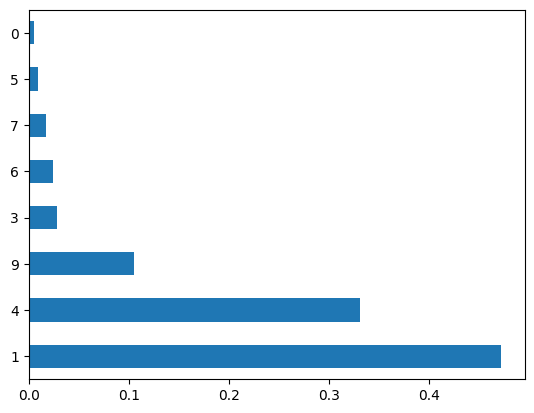

In [ ]:
# plotting feature importances
(pd.Series(importances.toArray().astype(float), index=importances.indices)
   .nlargest(8)
   .plot(kind='barh'))



Here we can observe that we have the feature 1,4,9,6,3 as our top 5 features. These are the Age,NumofProducts,IsActiveMember_cat,Geography_cat and Balance.<br>
So we will be using these features to build our Logistic regression model.

### Model Building 

#### Using the top 5 features

In [ ]:
top5_features =['Age','NumOfProducts','IsActiveMember_cat','Geography_cat','Balance']
# Now we will create our assemble using these features 
assembler=VectorAssembler(inputCols=[
'Age','NumOfProducts','IsActiveMember_cat','Geography_cat','Balance'],outputCol="features")
output=assembler.transform(indexed)
output.select(['features','churn_cat']).show(5)


+--------------------+---------+
|            features|churn_cat|
+--------------------+---------+
|(5,[0,1],[42.0,1.0])|      1.0|
|[41.0,1.0,0.0,2.0...|      0.0|
|[42.0,3.0,1.0,0.0...|      1.0|
|[39.0,2.0,1.0,0.0...|      0.0|
|[43.0,1.0,0.0,2.0...|      0.0|
+--------------------+---------+
only showing top 5 rows



#### Using Logistic Regression as our Model

In [ ]:
from pyspark.ml.classification import LogisticRegression
final_data_top=output.select(['features','churn_cat'])
train_data,test_data=final_data_top.randomSplit([0.7,0.3])
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churn_cat', maxIter=30)
lrModel = lr.fit(train_data)


##### log_summmary of our model

In [ ]:
log_summary=lrModel.summary
log_summary.predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- churn_cat: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
log_summary.predictions.show()

+--------------------+---------+--------------------+--------------------+----------+
|            features|churn_cat|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+----------+
|(5,[0,1],[18.0,2.0])|      0.0|[4.07696837227614...|[0.98332400431591...|       0.0|
|(5,[0,1],[18.0,2.0])|      0.0|[4.07696837227614...|[0.98332400431591...|       0.0|
|(5,[0,1],[18.0,2.0])|      0.0|[4.07696837227614...|[0.98332400431591...|       0.0|
|(5,[0,1],[18.0,2.0])|      1.0|[4.07696837227614...|[0.98332400431591...|       0.0|
|(5,[0,1],[19.0,2.0])|      0.0|[4.00402528728549...|[0.98208474972972...|       0.0|
|(5,[0,1],[19.0,2.0])|      0.0|[4.00402528728549...|[0.98208474972972...|       0.0|
|(5,[0,1],[19.0,2.0])|      0.0|[4.00402528728549...|[0.98208474972972...|       0.0|
|(5,[0,1],[20.0,1.0])|      0.0|[3.90976738233723...|[0.98034874915532...|       0.0|
|(5,[0,1],[20.0,1.0])|      0.0|[3.90976738233723...|[

##### coefficients 

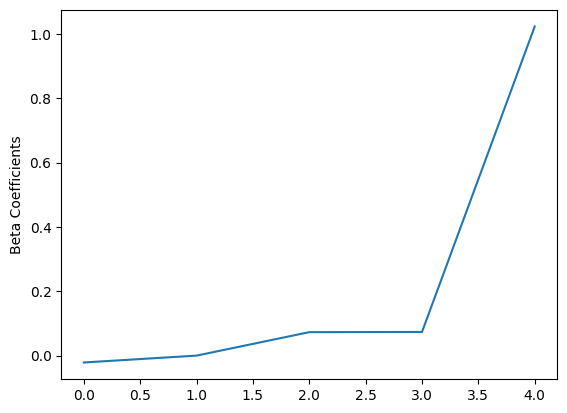

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


##### receiver-operating characteristic and areaUnderROC

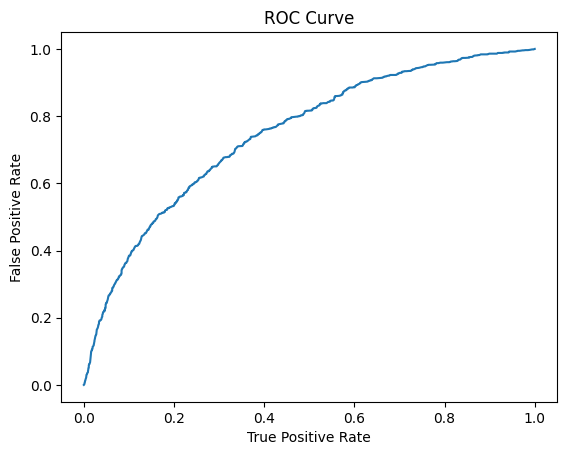

Training set areaUnderROC: 0.7467935543746776


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

##### Precision and recall

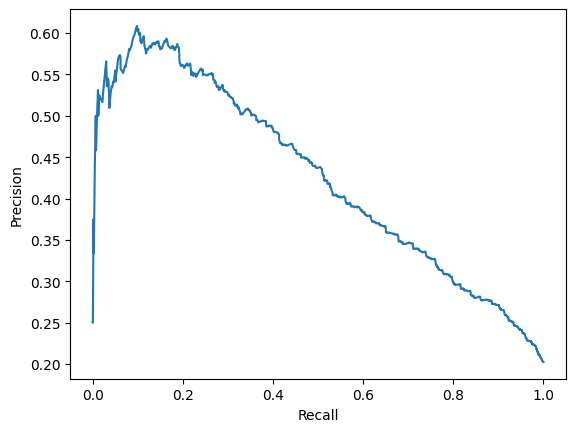

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

##### Make predictions on the test set

In [ ]:
predictions = lrModel.transform(test_data)
predictions.select('churn_cat','probability').show(5)

+---------+--------------------+
|churn_cat|         probability|
+---------+--------------------+
|      0.0|[0.98170585147638...|
|      0.0|[0.98208474972972...|
|      0.0|[0.98075520395469...|
|      0.0|[0.97889313832840...|
|      0.0|[0.97932906530295...|
+---------+--------------------+
only showing top 5 rows



##### Evaluate our Logistic Regression model.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='churn_cat')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7502363742038998


##### Intercept

In [ ]:
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))
coef=lrModel.coefficients

Coefficients: [0.07294308499065043,-0.021314819957610455,1.0233958936715106,0.07355371792107009,5.023773567010354e-06]
Intercept: -5.347314262192629


##### Other Evaluation Metrics

In [ ]:
trainingSummary = lrModel.summary
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8062767475035664
FPR: 0.6838834518251322
TPR: 0.8062767475035664
F-measure: 0.7572353203010409
Precision: 0.7709674391484447
Recall: 0.8062767475035664


##### AreaUnderROC

In [ ]:
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|5.365766410302271E-4|7.047216349541931E-4|
|8.942944017170453E-4|0.002114164904862...|
|0.001430871042747...|0.002818886539816...|
|0.001609729923090...|0.004933051444679351|
|0.001788588803434...|0.007047216349541931|
|0.002325165444464...|0.007751937984496124|
|0.002504024324807727|0.009866102889358703|
|0.002682883205151...|0.011980267794221282|
|0.003219459846181363|0.012684989429175475|
|0.003398318726524...|0.014799154334038054|
| 0.00375603648721159| 0.01620859760394644|
|0.004113754247898408|0.017618040873854827|
|0.004471472008585226|0.019027484143763214|
|0.004829189769272045|  0.0204369274136716|
|0.005186907529958...|0.021846370683579985|
|0.005365766410302...|0.023960535588442564|
| 0.00554462529064568|0.026074700493305146|
|0.005723484170989089|0.028188865398167725|
|0.005902343051332499|0.03030303

Thus we have successfully implemented Logistic Regression model.

### Interpreting the Data

1. The number of customers that churned is 20.37% (2,037) and that number that did not churn out is 79.63% (7,963).
2. Overall, the average credit score of customer who churned is 645.35 and the average age of the customers who churned is 44.83 years.
3. The average balance and the estimated salary of the customers who churned are 911,108.53 and 101,465.67 respectively, which is greater than
customers who didn't churn.
4. Customer age and churn are 29% positively correlated.
5. Balance and churn are 12% positively correlated.
6. Number of products and Balance are 30% negatively correlated.
7. The difference between churn and non-churn customers in Germany and Spain is less than in France.
8. Comparatively, more female customers have churned. The amount of churn is greater for customers with 3-4 products.
9. The amount of churn is less with customers with a negative-to-low balance compared to customers having a balance of 75,000–150,000.
10. The most important features selected from Random forest-based feature selection are Age, NumOfProducts, IsActiveMember, Geography_cat, Balance.

### Summary</b><br>
1. Predicting customer churn is one of the most common use cases in marketing analytics. Churn prediction not only helps marketing teams to better
strategize their marketing campaigns, but also helps organizations to focus their resources wisely.
2. Here we explored how to use the data science pipeline for any machine learning problem. We also learned the intuition behind using logistic
regression and saw how it is different from linear regression.
3. We looked at the structure of the data by reading it using a pandas DataFrame. We then used data scrubbing techniques such as missing value imputation,
renaming columns, and datatype manipulation to prepare our data for data exploration.
4. We implemented various data visualization techniques, such as univariate, bivariate, and a correlation plot, which enabled us to find useful insights from
the data.
5. Feature selection is another important part of data modeling. We used a Random-forest-based classifier to select important features for our machine learning model.
6. Finally, we implemented logistic regression to find out the likelihood of customer churn.`

In [ ]:
from pyspark.ml.classification import GBTClassifier
final_data_top = output.select(['features', 'churn_cat'])
train_data, test_data = final_data_top.randomSplit([0.7, 0.3])
gbt = GBTClassifier(featuresCol='features', labelCol='churn_cat', maxIter=10)
gbtModel = gbt.fit(train_data)